## 86.5점

In [1]:
import warnings
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D,Dropout, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D,AveragePooling2D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils, to_categorical
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/vne

In [2]:
# load dataset list

train_data = pd.read_csv("train_vision_aug_1.csv")
train_filename = train_data["filename"].values.tolist()
train_data["label"] = train_data["label"] -1
train_label = train_data["label"].values.tolist()

test_data = pd.read_csv("test_vision.csv")
test_filename = test_data["filename"].values.tolist()

print(len(train_filename), len(train_label), len(test_filename))

17548 17548 2000


In [3]:
# load train data
input_height , input_width = 128, 128
n_class = 6

def getImageArr(img_name):
        img = cv2.imread("faces_images/" + img_name, 1)
        img = np.float32(img) / 127.5 - 1   #0~255 를 평균 0이게 수정
        return img

X = []
for name in train_filename:
    X.append(getImageArr(name))
    
X, Y = np.array(X), to_categorical(np.array(train_label),n_class)
print(X.shape, Y.shape)

(17548, 128, 128, 3) (17548, 6)


In [4]:
# split dataset

train_rate = 0.8
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
# X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14038, 128, 128, 3) (14038, 6)
(3510, 128, 128, 3) (3510, 6)


In [5]:
# load test data

real_test = []
for name in test_filename:
    real_test.append(getImageArr(name))
    
real_test = np.array(real_test)
print(real_test.shape)

(2000, 128, 128, 3)


In [6]:
 def nn_base(nClasses, input_height=128, input_width=128):
        
    img_input = Input(shape=(input_height,input_width, 3))
        
    IMAGE_ORDERING =  "channels_last"
    
    x = Conv2D(filters=16, kernel_size=(7, 7), padding='same', name='image_array', data_format=IMAGE_ORDERING)(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters=16, kernel_size=(7, 7), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same', data_format=IMAGE_ORDERING)(x)
    x = Dropout(.5)(x)

    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(.5)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same', data_format=IMAGE_ORDERING)(x)
    x = Dropout(.5)(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same', data_format=IMAGE_ORDERING)(x)
    x = Dropout(.5)(x)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=nClasses, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = GlobalAveragePooling2D(data_format=IMAGE_ORDERING)(x)
    x = Activation('softmax', name='predictions')(x)
    
    model = Model(img_input, x)
    
    return model

In [7]:
model = nn_base(nClasses  = n_class,  
             input_height = 128, 
             input_width  = 128)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
image_array (Conv2D)         (None, 128, 128, 16)      2368      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      12560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 16)        0         
__________

In [9]:
with K.tf.device('/gpu:1'):
    adam = optimizers.Adam(lr=1E-2, decay=5**(-4))
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

    hist1 = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      batch_size=32,epochs=20)

Train on 14038 samples, validate on 3510 samples
Epoch 1/20
14038/14038 [==============================] - 22s 2ms/step - loss: 0.6651 - acc: 0.7621 - val_loss: 0.5116 - val_acc: 0.8100
Epoch 2/20
14038/14038 [==============================] - 20s 1ms/step - loss: 0.5114 - acc: 0.8181 - val_loss: 0.5132 - val_acc: 0.8066
Epoch 3/20
14038/14038 [==============================] - 21s 1ms/step - loss: 0.4494 - acc: 0.8353 - val_loss: 0.5038 - val_acc: 0.8151
Epoch 4/20
14038/14038 [==============================] - 21s 2ms/step - loss: 0.4086 - acc: 0.8565 - val_loss: 0.4019 - val_acc: 0.8470
Epoch 5/20
14038/14038 [==============================] - 21s 2ms/step - loss: 0.3866 - acc: 0.8591 - val_loss: 0.3718 - val_acc: 0.8766
Epoch 6/20
14038/14038 [==============================] - 21s 2ms/step - loss: 0.3730 - acc: 0.8638 - val_loss: 0.3619 - val_acc: 0.8738
Epoch 7/20
14038/14038 [==============================] - 21s 2ms/step - loss: 0.3512 - acc: 0.8761 - val_loss: 0.3064 - val_acc:

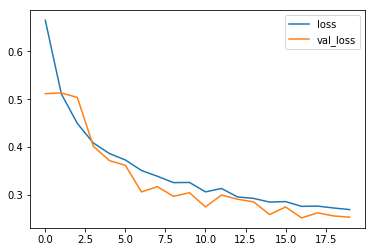

In [10]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [11]:
y_pred = model.predict(real_test)
y_predi = np.argmax(y_pred,axis = 1) + 1
print(np.unique(y_predi), y_predi.shape)

[1 2 3 4 5 6] (2000,)


In [12]:
answer = pd.DataFrame({"prediction":y_predi})

In [13]:
answer.to_csv('results/6-3.csv',index=False, header="label")